In [143]:
import sys
import os
import json
import pandas as pd
from collections import defaultdict
import seaborn as sns
from matplotlib import pyplot as plt
from copy import deepcopy

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

In [4]:
from src.evaluation import RecallKTitles
from src.models.modules import BookDescriptionEmbeddingSimilarity


k = 1000
recs_path = os.path.join(PROJECT_ROOT, "data/test_data/tests.json")
model_path = os.path.join(PROJECT_ROOT, "data/embeddings/books_embeddings_dataset.npy")
dataset_path = os.path.join(PROJECT_ROOT, "data/raw_data/LEHABOOKS.csv")
model = BookDescriptionEmbeddingSimilarity(model_path)

books = pd.read_csv(dataset_path)
books_list = books["Title"].to_list()

In [16]:
DST_PATH = os.path.join(PROJECT_ROOT, "data", "test_data", "dst.json") 
with open(DST_PATH, "r", encoding="utf-8") as f:
    recs = json.load(f)


for book_entry in recs:
    if book_entry["title"] not in books_list:
        print(book_entry["title"])
    for rec in book_entry["recommendations"]:
        if rec not in books_list:
            print(book_entry["title"], rec)


print("--------")
for book in books_list:
    if "" in book.lower():
        print(book)

1984 The Road
War and Peace The Seagull
War and Peace Uncle Vanya
War and Peace The Captain's Daughter
Crime and Punishment The Seagull
Crime and Punishment Uncle Vanya
Crime and Punishment The Captain's Daughter
Anna Karenina The Seagull
Anna Karenina Uncle Vanya
Anna Karenina The Captain's Daughter
The Brothers Karamazov The Seagull
The Brothers Karamazov Uncle Vanya
The Brothers Karamazov The Captain's Daughter
The Master and Margarita The Seagull
The Master and Margarita Uncle Vanya
The Master and Margarita The Captain's Daughter
--------


In [38]:
RECS_PATH = os.path.join(PROJECT_ROOT, "data", "test_data", "dst.json") 
with open(RECS_PATH, "r", encoding="utf-8") as f:
    recs = json.load(f)

print(len(recs))

for rec_entry in recs:
    if rec_entry["title"] not in books_list:
        print(rec_entry["title"])
    for book_entry in rec_entry["recommendations"]:
        if book_entry not in books_list:
            pass
cleared_recs = []

for rec_entry in recs:
    cleared_recs.append({
        "title": rec_entry["title"],
        "recommendations": [book for book in rec_entry["recommendations"] if book in books_list]
    })

CLEARED_RECS_PATH = os.path.join(PROJECT_ROOT, "data", "test_data", "cleared_gpt.json") 
with open(CLEARED_RECS_PATH, "w", encoding="utf-8") as f:
    json.dump(cleared_recs, f, ensure_ascii=False, indent=4)

20


In [ ]:
class Metrics():
    def __init__(self, model, books_list, k):
        self.model = model
        self.books_list = books_list
        self.recs_path = CLEARED_RECS_PATH
        self.k = k

        with open(self.recs_path, "r", encoding="utf-8") as f:
            self.recs = json.load(f)

    
    def __model_results(self, title):
        return self.model.recommend_by_title(title, n=self.k)
    
    def __hit_ratio(self, preds, recs):
        preds, recs = set(preds), set(recs)
        return any([book in preds for book in recs])
    
    def __confussion_matrix(self, preds, recs):
        preds, recs = set(preds), set(recs)
        matrix = {}
        matrix["TP"] = len([book for book in preds if book in recs])
        matrix["FP"] = len([book for book in preds if book not in recs])
        matrix["FN"] = len([book for book in recs if book not in preds])
        matrix["TN"] = -1
        return matrix

    def __reciprocal_rank(self, preds, recs):
        indexes = [index for index in range(len(preds)) if preds[index] in recs]
        if len(indexes) == 0:
            return 0
        return 1 / indexes[0]

    def __recall(self, preds, recs):
        preds, recs = set(preds), set(recs)
        return len([book for book in preds if book in recs]) / len(recs)
    
    def __precision(self, preds, recs):
        preds, recs = set(preds), set(recs)
        return len([book for book in preds if book in recs]) / len(preds)
    

    def stats(self):
        results=defaultdict(list)

        for book_entry in self.recs:
            title = book_entry["title"]
            preds = [title for title, _ in self.__model_results(title)]
            recs = book_entry["recommendations"]
            hit_ratio = self.__hit_ratio(preds, recs)
            recall = self.__recall(preds, recs)
            precision = self.__precision(preds, recs)
            matrix = self.__confussion_matrix(preds, recs)
            reciprocal_rank = self.__reciprocal_rank(preds, recs)

            results["hit_ratio"].append(hit_ratio)
            results["recall"].append(recall)
            results["precision"].append(precision)
            results["matrix"].append(matrix)
            results["reciprocal_rank"].append(reciprocal_rank)

        return results
    
    def average_stats(self, results=None):
        if results == None:
            results = self.stats()

        results_average = {}
        results_average["hit_ratio_average"] = [sum(results["hit_ratio"]) / len(results["hit_ratio"])]
        results_average["recall_average"] = sum(results["recall"]) / len(results["recall"])
        results_average["precision_average"] = sum(results["precision"]) / len(results["precision"])
        results_average["mean_reciprocal_rank"] = sum(results["reciprocal_rank"]) / len(results["reciprocal_rank"])
        
        # resulting_matrix = results["matrix"]
        # resulting_matrix["TP"] = sum([matrix["TP"] for matrix in resulting_matrix])
        # resulting_matrix["FP"] = sum([matrix["FP"] for matrix in resulting_matrix])
        # resulting_matrix["FN"] = sum([matrix["FN"] for matrix in resulting_matrix])
        # resulting_matrix["TN"] = -1
        # results["matrix"] = resulting_matrix

        return results_average
    
    def graph_stats(self, results, results_average):

        
        sns.lineplot(data=results)

        length = len(results["recall"])
        results_average = deepcopy(results_average)
        results_average["hit_ratio_average"] = [results_average["hit_ratio_average"]] * length
        results_average["precision_average"] = [results_average["precision_average"]] * length
        results_average["recall_average"] = [results_average["recall_average"]] * length
        results_average["mean_reciprocal_rank"] = [results_average["mean_reciprocal_rank"]] * length
        sns.lineplot(data=results_average)

In [141]:
metrics = Metrics(model=model, books_list=books_list, k=1000)

In [139]:
metrics = Metrics(model=model, books_list=books_list, k=1000)
results=metrics.stats()
results_average=metrics.average_stats(results=results)

AttributeError: 'dict' object has no attribute 'deepcopy'

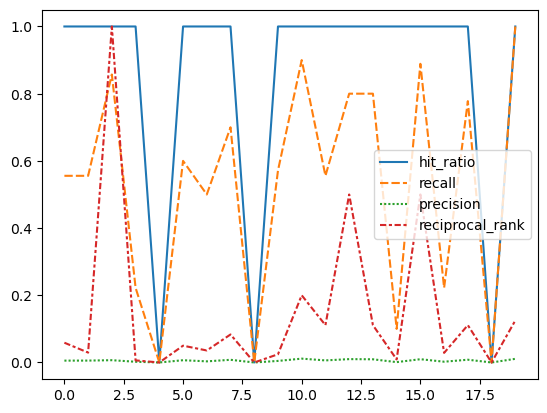

In [142]:
metrics.graph_stats(results, results_average)